# Ac-225 Advanced PSF Modeling (SIMIND)

This tutorial uses the PSF operators obtained using the SPECTPSF toolbox to reconstruct Ac225 data. The operator was obtained using tutorial 5, available at this [link](https://github.com/lukepolson/SPECTPSFToolbox/blob/main/tutorials/5_optimization_ac225.ipynb). Use of this operator requires the SPECTPSFToolbox to be installed; instructions for installing can be found on the README [here](https://github.com/lukepolson/SPECTPSFToolbox/tree/main)

In [1]:
import os
import torch
import dill
import pytomography
from pytomography.io.SPECT import simind
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT  import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.io.SPECT.shared import subsample_projections_and_modify_metadata, subsample_amap
from pytomography.likelihoods import PoissonLogLikelihood
import matplotlib.pyplot as plt

In [2]:
# change to where you saved the data
PATH = '/mnt/mydisk2/pytomo_tutorial_data/SPECT/SIMIND-Jaszak'

Load the SIMIND data. In this case, we'll use the ground truth scatter from SIMIND.

In [3]:
dT = 2.5 * 60 # seconds per projection
activity_conc = 10 # kBq/L, a very high activity conc for Ac225
CPSpMBq = 17 # an approximate calibration factor

# Specify the isotopes and equilibirum ratios based on Bateman equations
isotopes = ['ac225', 'bi213', 'fr221', 'tl209']
isotopes_ratios = [1,1,1,0.0209] 
# look at the .h00 files; there are many E windows simulated. These are 5% scat win for 440peak
i_peak, i_lower, i_upper = 10, 11, 14 
files_NM = [[os.path.join(PATH, f'{isotope}', f'tot_w{i}.h00') for isotope in isotopes] for i in [i_lower, i_peak, i_upper]]
object_meta, proj_meta = simind.get_metadata(files_NM[0][0])
activity_concs = [activity_conc * ratio for ratio in isotopes_ratios]
projections = simind.get_projections(files_NM, activity_concs)
projections *= dT

# Based on how they are loaded, this is idx of peak, lower upper
idx_peak, idx_lower, idx_upper = 1, 0, 2
photopeak = projections[idx_peak]
ww_lower, ww_peak, ww_upper = [simind.get_energy_window_width(path) for path in [files_NM[0][0], files_NM[0][1], files_NM[0][2]]]
scatter_estimate_TEW = simind.compute_EW_scatter(
    projections[idx_lower], projections[idx_upper],
    ww_lower,
    ww_upper,
    ww_peak,
    sigma_r=0.5,
    sigma_z=0.5,
    proj_meta=proj_meta
)

We're reconstructing the 440keV window so we'll use the 440keV attenuation map

In [4]:
path_amap = os.path.join(PATH, 'attenuation_maps', 'amap440.hct')
amap = simind.get_attenuation_map(path_amap)

The code below reconstructs using OSEM with 50 iterations and 4 subsets

In [5]:
def perform_reconstruction(psf_transform):
    att_transform = SPECTAttenuationTransform(attenuation_map=amap)
    system_matrix = SPECTSystemMatrix(
            obj2obj_transforms = [att_transform,psf_transform],
            proj2proj_transforms = [],
            object_meta = object_meta,
            proj_meta = proj_meta)
    likelihood = PoissonLogLikelihood(system_matrix, photopeak, scatter_estimate_TEW)
    algorithm = OSEM(likelihood)
    return algorithm(n_iters=50, n_subsets=4)

Open the PSF operator created in [this tutorial](https://github.com/lukepolson/SPECTPSFToolbox/blob/main/tutorials/5_optimization_ac225.ipynb)

In [6]:
# Note that you may need to create this operator yourself with the SPECTPSFToolbox to match your GPU architecture
with open(os.path.join(PATH, 'ac225_psf_operator.pkl'), 'rb') as f:
    psf_operator = dill.load(f)
psf_operator.set_device(pytomography.device)
psf_transform = SPECTPSFTransform(psf_operator=psf_operator)
recon_1Dfit = perform_reconstruction(psf_transform)

Reconstruct using the Gaussian modeling which doesn't account for the septal penetration and septal scatter:

In [7]:
path_bi213_prim = files_NM[1][1]
psf_meta = simind.get_psfmeta_from_header(path_bi213_prim)
psf_transform = SPECTPSFTransform(psf_meta)
reconbad = perform_reconstruction(psf_transform)

Lets compare the two reconstructions: the first one using the fitted PSF and the second one using the Monte Carlo kernels. Note that the fitted one was over twice as fast for reconstructing!

In [8]:
recons = [reconbad, recon_1Dfit]
titles = ['Gaussian PSF', 'Full PSF']

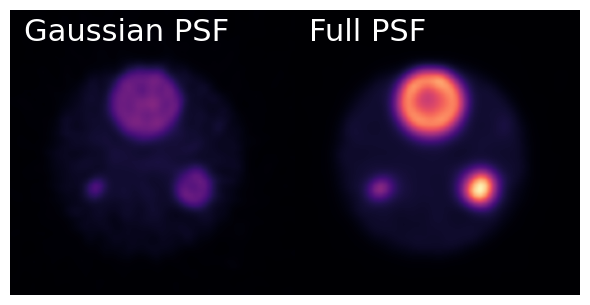

In [26]:
fig, ax = plt.subplots(1,2,figsize=(6,4), gridspec_kw={'wspace':0.0})
vmax = recons[1].max()
for i in range(2):
    plt.sca(ax[i])
    plt.imshow(recons[i].cpu()[:,:,64].T, cmap='magma', interpolation='gaussian', vmax=vmax)
    plt.text(0.05, 0.87, titles[i], ha='left', va='bottom', fontsize=22, transform=ax[i].transAxes, color='white')
    plt.axis('off')
    plt.xlim(35,95)
    plt.ylim(35,95)
fig.tight_layout()